**Objectif**

Dans ce fichier, notre objectif est de rendre nos données stationnaires. Ainsi, nous avons suivi les étapes suivantes : 

**Démarche**

1) Analyse graphique de la stationnarité
2) identification de l'origine de la non-stationnarité
3) Rendre les séries temporelles stationnaires
4) Analyse de l'auto-corrélation
5) Analyse de la volatilité des variables explicatives
6) Différenciation de second ordre
7) Combinaison des données stationnaires
8) Combiner les indicateurs de récession aux données stationnaires
9) Graphiques des variables originales et stationnaires côte à côte
10) Exporter la série stationnaire

**Conclusion**

La conclusion de ce fichier est que que : 
- Le target, le taux de chômage (UNRATE) est déjà stationnaire. Il a été différencié toutefois puisqu'on voulait expliquer le taux de croissance du chômage dans ce projet.
- Voici les variables assurément stationnaires avec l'ordre 1 : 
    - INDPRO :activité industrielle 
    - RPI : revenu personnel réel des ménages
    - S&P 500 : indice boursier représentatif du marché actions américain
    - DPCERA3M086SBEA : dépenses de consommation réelles.
    - TB3MS : taux d’intérêt à court terme
- Pour avoir une explication de chaque variable en termes de croissance, le TB3MS (un taux) a été différencié en point contrairement aux autres avec un log.
- A cause d'une mémoire longue présente dans les variables suivantes ou exceptionnellement pour sa volatilité (OILPRICEx), une seconde différenciation a été nécessaire : 
    - BUSLOANS : prêts bancaires aux entreprises
    - CPIAUCLS : indice des prix à la consommation (inflation)
    - M2SL : masse monétaire au sens large
    - OILPRICEx : prix du baril de pétrole
- USREC indique la présence d'une période de récision ou non

**Next action :** 
splitter les données TRAIN-TEST

# Packages

In [ ]:
import pandas as pd
import pandas_datareader.data as web
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

import matplotlib.dates as mdates

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from datetime import datetime

# Package

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, kpss
import statsmodels.api as sm


# Importer données

In [35]:
df = pd.read_csv("df.csv", index_col="date")
print(df.head())

            UNRATE  TB3MS       RPI   INDPRO  DPCERA3M086SBEA  S&P 500  \
date                                                                     
1959-01-01     6.0   2.82  2583.560  21.9616           15.188    55.62   
1959-02-01     5.9   2.70  2593.596  22.3917           15.346    54.77   
1959-03-01     5.6   2.80  2610.396  22.7142           15.491    56.16   
1959-04-01     5.2   2.95  2627.446  23.1981           15.435    57.10   
1959-05-01     5.1   2.84  2642.720  23.5476           15.622    57.96   

            BUSLOANS  CPIAUCSL  OILPRICEx   M2SL  
date                                              
1959-01-01   35.2130     29.01       3.00  286.6  
1959-02-01   35.2201     29.00       3.00  287.7  
1959-03-01   35.1304     28.97       2.97  289.2  
1959-04-01   35.5581     28.98       2.97  290.1  
1959-05-01   36.3064     29.04       2.97  292.2  


## 1. Analyse graphique de stationnarité

In [155]:
# ---------- 1) Données originales -> long ----------
df = df.copy()
df.index.name = "date"
df.index = pd.to_datetime(df.index)

df_long_orig = (
    df.reset_index()
      .melt(id_vars="date", var_name="series", value_name="value")
      .dropna(subset=["value"])
      .sort_values(["series", "date"])
      .assign(type="Original")
)

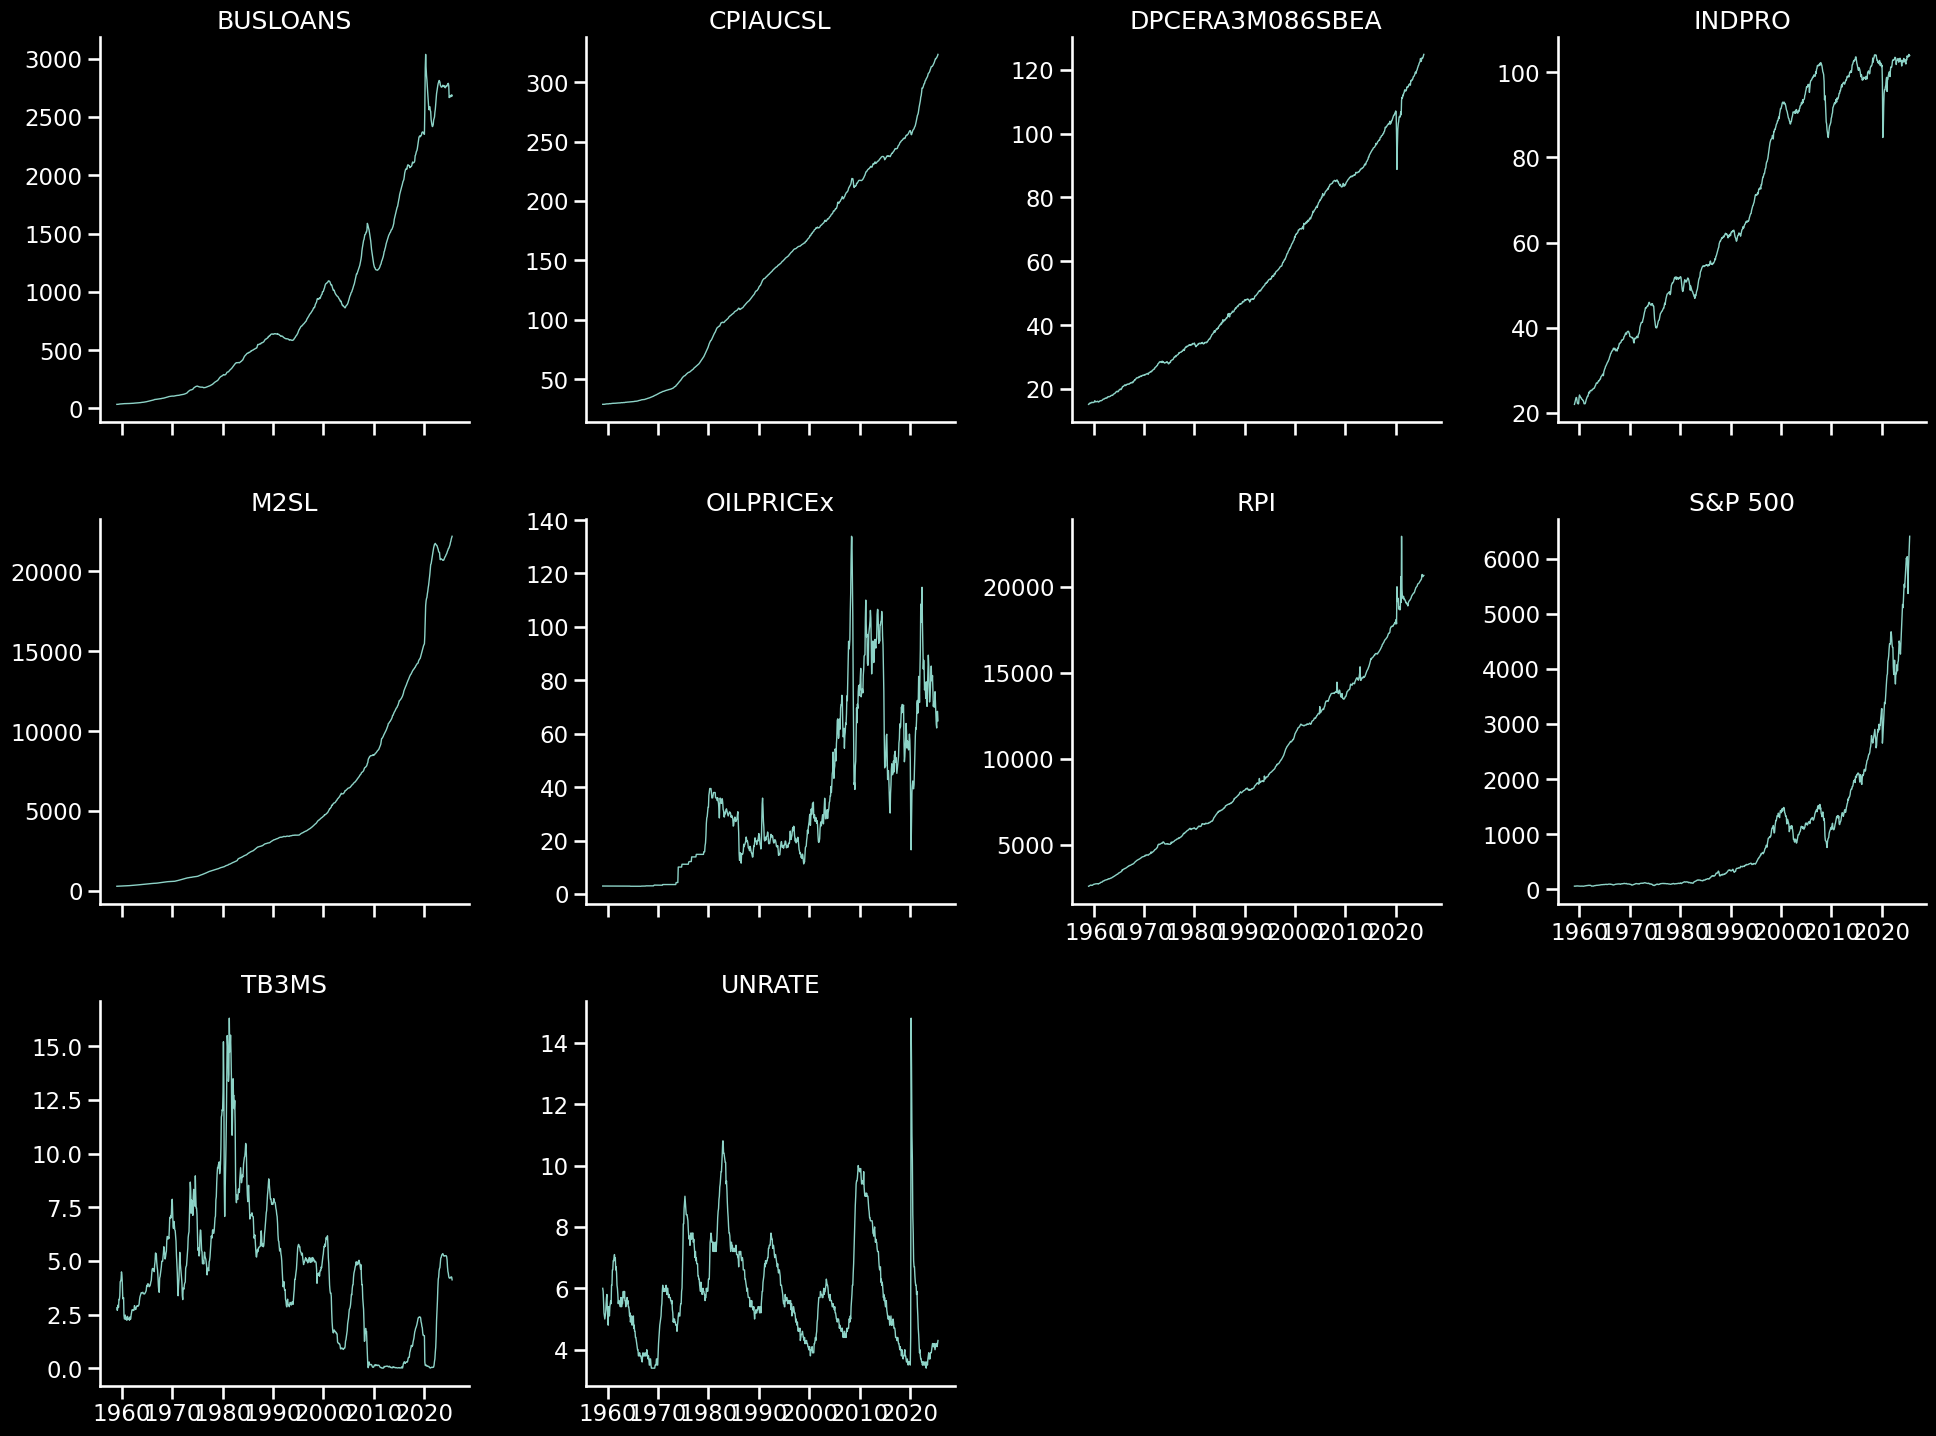

In [156]:
# Présentation des graphique
plt.style.use("dark_background")

g = sns.relplot(
    data=df_long_orig,
    x="date", y="value",
    col="series", col_wrap=4,
    kind="line", linewidth=1,
    facet_kws=dict(sharey=False),
    hue=None, legend=False
)

g.set_axis_labels("", "")
g.set_titles("{col_name}")

for ax in g.axes.flat:
    ax.tick_params(axis="x", labelrotation=0, colors="white")
    ax.tick_params(axis="y", colors="white")
    ax.grid(False) 

plt.show()

Vu que le taux de chômage et le monthly treasure bill rate sont en pourcentage, ils sont très proche de l'état stationnaire (moyenne = 0  et variance stable). Le monthly treasure bill est un peu volatile. La variance commence à bouger sur l'OIL price tandis que la tendance à la hausse est la règle pour le reste. 

En clair, nos données sont toutes à priori non-stationnaires. Il faut cependant justifier cette analyse par des tests de stationnarités et identifier aussi l'origine de la non-stationnarité. 

## 2) Identifier l'origine de la non-stationnarité

### 📌 Workflow — Test Dickey–Fuller (Modèle 1)

---

**Modèle à estimer**

$$
\Delta y_t = c + \beta_1 t + \gamma y_{t-1} + \varepsilon_t
$$

---

**Étape 1 — Tester la présence d’une racine unitaire**

Hypothèse :

$$
H_0 : \gamma = 0
$$

→ Test Dickey–Fuller (seuil critique = *tau3*)

---

### ✅ CAS A — Racine unitaire présente
Décision : non-rejet de H₀ : γ = 0
Conséquence : présence d’une racine unitaire
Valeur de la racine : φ₁ = 1

**A1 — Tester si au moins un des paramètres est ≠ 0**

Test de Fisher :

$$
H_0^2 : c = \gamma = \beta_1 = 0
$$

- **Si rejet de \(H_0^2\)** :

  Variation stationnaire :

  $$
  \Delta y_t = c + \beta_1 t + \varepsilon_t
  $$

  Conclusion :

  $$
  y_t \sim I(1)
  $$

- **Si non-rejet de \(H_0^2\)** :

  Estimation du **Modèle 2** :

  $$
  \Delta y_t = c + \gamma y_{t-1} + \varepsilon_t
  $$

---

### ✅ CAS B — Pas de racine unitaire
Décision : rejet de H₀ : γ = 0
Conséquence : absence de racine unitaire
Valeur de la racine : |φ₁| < 1

**B1 — Tester la significativité du trend**

Test Student :

$$
H_0 : \beta_1 = 0
$$

- **Si rejet de \(H_0\)** :

  $$
  y_t \text{ est TS avec trend}
  $$

  $$
  \Delta y_t \text{ est TS}
  $$

- **Si non-rejet de \(H_0\)** :

  Estimation du **Modèle 2** :

  $$
  \Delta y_t = c + \gamma y_{t-1} + \varepsilon_t
  $$

---

In [64]:
# === Test ADF (tau3) : racine unitaire ===
def test_adf_trend(series, autolag="AIC"):
    """
    Test ADF (tau3) avec constante et tendance (regression='ct').

    Paramètres
    ----------
    series : array-like
        Série temporelle.
    autolag : str, optionnel
        Critère de sélection des retards (par défaut : "AIC").

    Retour
    ------
    dict : {'adf_stat', 'adf_pval', 'usedlag'}
    """
    y = pd.Series(series).dropna()
    adf_res = adfuller(y, regression="ct", autolag=autolag)
    return {
        "adf_stat": adf_res[0],
        "adf_pval": adf_res[1],
        "usedlag": adf_res[2]
    }

In [65]:
# === Helpers pour choix du lag de diff ===
def diff_l(series, l):
    """Retourne la série différenciée d'ordre l."""
    s = pd.Series(series)
    return s - s.shift(l)

def adf_ct_pval(x, autolag="AIC"):
    """Renvoie la p-value et le lag retenu du test ADF avec constante et tendance."""
    y = pd.Series(x).dropna()
    if len(y) < 20:
        return np.nan, None
    stat, pval, usedlag, *_ = adfuller(y, regression="ct", autolag=autolag)
    return pval, usedlag

def find_opt_diff_lag(series, candidates=(1,3,6,12), alpha=ALPHA, autolag="AIC"):
    """
    Recherche le lag optimal de différenciation via un test ADF.
    Renvoie (opt_lag, details, best_l).
    """
    details = {}
    best_l, best_p = None, np.inf
    for l in candidates:
        dy = diff_l(series, l)
        pval, usedlag = adf_ct_pval(dy, autolag=autolag)
        details[l] = {"pval": pval, "usedlag": usedlag}
        if pval is not None and not np.isnan(pval):
            if pval < best_p:
                best_p, best_l = pval, l

    passing = [l for l, d in details.items() if d["pval"] is not None and d["pval"] < alpha]
    opt_lag = min(passing) if passing else None
    return opt_lag, details, best_l

In [66]:
# === 2) Modèle 1 : estimation OLS ===
def estimate_model1(series, lags):
    """
    Estime un modèle ADF avec constante, tendance et retards de la différence.
    Renvoie les résultats OLS statsmodels.
    """
    y = pd.Series(series).dropna()
    dy = y.diff()
    y_lag = y.shift(1)
    trend = np.arange(1, len(y) + 1)

    X = pd.DataFrame({"const": 1.0, "trend": trend, "y_lag": y_lag}, index=y.index)

    # Ajouter les retards de Δy
    for i in range(1, lags + 1):
        X[f"dy_lag{i}"] = dy.shift(i)

    df_model = pd.concat([dy, X], axis=1).dropna()
    dy_aligned = df_model.iloc[:, 0]
    X_aligned = df_model.iloc[:, 1:]
    ols_res = sm.OLS(dy_aligned, X_aligned).fit()
    return ols_res

In [ ]:
# === 3) Test de Fisher (φ2) ===
def test_fisher_phi2(ols_res):
    """
    Effectue un test F pour les coefficients const, trend et y_lag.
    Renvoie les valeurs F et p-value.
    """
    f_test = ols_res.f_test("const = 0, trend = 0, y_lag = 0")
    return {"phi2_F": float(f_test.fvalue), "phi2_pval": float(f_test.pvalue)}

In [ ]:
# === 4) Analyse d'une série ===
def analyse_series(series, name, alpha=ALPHA):
    """
    Analyse une série via ADF, estimation OLS et test de Fisher.
    Renvoie un dictionnaire de résultats et une conclusion.
    """
    adf_out = test_adf_trend(series)
    ols_res = estimate_model1(series, adf_out["usedlag"])

    # Chercher un l optimal pour Δ_l y_t
    opt_lag, opt_scan, best_l = find_opt_diff_lag(series, candidates=(1,3,6,12), alpha=alpha)

    results = {
        "ADF stat (tau3)": adf_out["adf_stat"],
        "ADF p-value": adf_out["adf_pval"],
        "lags used (ADF)": adf_out["usedlag"],
        "beta1": ols_res.params.get("trend", np.nan),
        "beta1 p-value": ols_res.pvalues.get("trend", np.nan),
        "opt_diff_lag": opt_lag,
        "best_diff_lag": best_l,
        "scan_pvals": {l: d["pval"] for l, d in opt_scan.items()}
    }

    # Décision finale sur y_t
    if adf_out["adf_pval"] < alpha:
        if results["beta1 p-value"] < alpha:
            results["Conclusion"] = "Stationnaire autour d’une tendance (TS)"
        else:
            results["Conclusion"] = "Stationnaire sans tendance significative"
    else:
        fisher_out = test_fisher_phi2(ols_res)
        results.update(fisher_out)
        if fisher_out["phi2_pval"] < alpha:
            results["Conclusion"] = "Δy_t est TS, donc y_t est I(1)"
        else:
            results["Conclusion"] = "y_t est une marche aléatoire pure (RW)"
    return results

In [67]:
# === 5) Application au DataFrame ===
def analyse_dataframe(df):
    """
    Analyse chaque série du DataFrame et renvoie un tableau large avec les résultats.
    """
    rows = {}
    for col in df.columns:
        rows[col] = analyse_series(df[col], col)
    return pd.DataFrame(rows).T

In [68]:
# --- Exécution ---
summary = analyse_dataframe(df)

# Lags à afficher en colonnes
LAGS_VIEW = [1, 3, 6, 12]

# Construire colonnes Δ_l (p-values + indicateur stationnarité)
scan_cols = {f"ADF p(Δ{l})": [] for l in LAGS_VIEW}
scan_cols.update({f"Stat Δ{l} (p<{ALPHA})": [] for l in LAGS_VIEW})

index_vals = []
for serie, res in summary.iterrows():
    index_vals.append(serie)
    scan = res.get("scan_pvals", {}) or {}
    for l in LAGS_VIEW:
        p = scan.get(l, np.nan)
        scan_cols[f"ADF p(Δ{l})"].append(p)
        if p is None or (isinstance(p, float) and np.isnan(p)):
            scan_cols[f"Stat Δ{l} (p<{ALPHA})"].append(np.nan)
        else:
            scan_cols[f"Stat Δ{l} (p<{ALPHA})"].append(bool(p < ALPHA))

df_scan_wide = pd.DataFrame(scan_cols, index=index_vals)

# Combiner avec le résumé niveau (en retirant la colonne scan_pvals brute)
base_cols = [c for c in summary.columns if c != "scan_pvals"]
df_wide = pd.concat([summary[base_cols], df_scan_wide], axis=1)

# Ordonner les colonnes principales
ordered = [
    "ADF stat (tau3)", "ADF p-value", "beta1", "beta1 p-value",
    "phi2_F", "phi2_pval", "Conclusion",
    "opt_diff_lag", "best_diff_lag",
] + [f"ADF p(Δ{l})" for l in LAGS_VIEW] + [f"Stat Δ{l} (p<{ALPHA})" for l in LAGS_VIEW]
ordered = [c for c in ordered if c in df_wide.columns]

# Affichage propre (toutes colonnes)
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.width', 200, 'display.max_colwidth', None):
    print(df_wide.reindex(columns=ordered))

                ADF stat (tau3) ADF p-value     beta1 beta1 p-value     phi2_F phi2_pval                                Conclusion opt_diff_lag best_diff_lag     ADF p(Δ1)     ADF p(Δ3)  \
UNRATE                -3.440606    0.046194 -0.000028      0.668239        NaN       NaN  Stationnaire sans tendance significative            1             1  1.362925e-22  1.268912e-06   
TB3MS                 -2.980016    0.137754 -0.000121      0.064486   2.996165   0.03008            Δy_t est TS, donc y_t est I(1)            1            12  2.545625e-07  6.965768e-07   
RPI                   -0.458905    0.984961  0.162572      0.305725   12.16733       0.0            Δy_t est TS, donc y_t est I(1)            1             3  2.171676e-10  5.731398e-11   
INDPRO                -2.318422    0.423788  0.001184      0.031527   4.229567  0.005602            Δy_t est TS, donc y_t est I(1)            1             1  8.402623e-10  1.821815e-08   
DPCERA3M086SBEA       -0.457154    0.985022  0.000602  

## Origine de la non stationnarité : 
- Contrairement à toutes les séries temporelles, le taux de chômage est stationnaire à niveau. il n'a pas aussi une tendance significative. Ces résultats sont normaux, puisque le taux de chômage est un taux.
- Dans n'importe quelle variable predicators, au moins un des termes déterministes suivantes causent la non-stationnarité : 
    - la tendance puisqu'on s'aperçoit que la majorité des séries temporelles augmentent dans le temps ; 
    - le drift puisque le niveau moyen est tout simplement non nul même si on ne voit pas clairement une tendance visible. 
- Si on revient sur le graphique pour précier, voici les séries temporelles dont la tendance explique la non-stationnarité :
    - Busloans : Commercial and Industrial Loans, billions of U.S. dollars ; 
    - CPIAUCL : Consumer Price Index for All Urban Consumers, index (1982–84 = 100) ; 
    - DPCERA3M086SBEA: Real Personal Consumption Expenditures, billions of chained 2012 U.S. dollars (SAAR) ; 
    - M2SL : M2 Money Stock, billions of U.S. dollars ; 
    - RPI : Real Personal Income, billions of chained 2012 U.S. dollars (SAAR) ; 
    - S&P500 : Standard & Poor’s 500 Index, index level (price index, no dividends).
    
- Pour le TB3MS, c'est plutôt le drift (au sens restreint çi-dessus) qui explique sa non stationnarité. TB3MS : 3-Month Treasury Bill Rate, percent per annum (yield).

- Pour le prix du baril de pétrol OILPRICEx, la série temporelle est déjà stationnaire autour d'une tendance. 

Le reste ne sont pas stationnaires. La différenciation d'ordre 1 ne signifie pas que le nombre de lag optimal est égal à 1. Nous pouvons encore appliquer un lag = 1, 3, 6, 12 mais avec une seule différenciation.

# Que faire? 
1. Cible (UNRATE)
- Objectif : prédire la variation annuelle du chômage.
- Transformation : Δ12 UNRATE (même si stationnaire en niveau).
- Justification : cohérent avec l’horizon de prévision (12 mois).

3. Pourquoi Δ3 pour les prédicteurs ?
- Stationnarité garantie.
- Compromis bruit / signal : Δ1 trop volatil, Δ12 trop lent.
- Pertinence économique : capte des signaux trimestriels anticipant l’évolution annuelle du chômage.
- et surtout recommandé dans la base FRED-MD (McCracken & Ng, 2016) pour la plupart des séries.

2. Cas spécifiques
- TB3MS (taux d’intérêt) : le taux ne se logge pas ; il faut faire une variation trimestrielle en points.
- Les autres séries vont être transformées en logarithmes. Pourquoi? C'est pour obtenir des séries stationnaires mais aussi interprétables économiquement en termes de croissance. 
- OilpriceX : Même si cette variable est déjà stationnaire, il faut l'appliquer le log différence pour un souci d'interprétation.


Résumé :
- Target : Δ12 UNRATE.
- Features : Δ3 (niveau pour TB3MS, log-diff pour les autres).

# 3) Rendre les séries stationnaires

In [70]:
# === Helpers pour choix du lag de diff ===
def diff_l(series, l):
    """Retourne la série différenciée d'ordre l."""
    s = pd.Series(series)
    return s - s.shift(l)

In [ ]:
# ========= 1) Petites fonctions de base =========
# Ne pas utiliser car j'ai déjà défini en haut 
#def diff_simple(series: pd.Series, lags: int) -> pd.Series:
#    """Δ_l x_t = x_t - x_{t-l}"""
#    s = pd.Series(series).astype(float)
#    return s.diff(lags)

In [71]:
def log_diff(series: pd.Series, lags: int) -> pd.Series:
    """
    Retourne la série différenciée des logarithmes en ignorant les valeurs non-positives.
    """
    s = pd.Series(series).astype(float)
    s = s.where(s > 0)
    return np.log(s).diff(lags)

In [72]:
def adf_test(series: pd.Series, alpha: float = 0.05, regression: str = "ct", autolag: str = "AIC") -> dict:
    """
    Test ADF standardisé avec options pour la tendance et la sélection de retards.
    Renvoie un dictionnaire contenant stat, p-value, lags, seuils critiques et décision.
    """
    y = pd.Series(series).astype(float).replace([np.inf, -np.inf], np.nan).dropna()
    if len(y) < 20:
        return {"ok": False, "reason": "insufficient_data", "nobs": len(y)}
    stat, pval, usedlag, nobs, crit, icbest = adfuller(y, regression=regression, autolag=autolag)
    return {
        "ok": True, "stat": float(stat), "pval": float(pval),
        "lags": int(usedlag), "nobs": int(nobs), "crit": crit,
        "stationary": (pval < alpha)
    }

In [57]:
# ========= 2) Fonctions “règles” et transformation d’une série =========

In [73]:
def choose_rule(col_name: str, rules: dict) -> dict:
    """
    Sélectionne la règle associée à un nom de colonne, ou la règle par défaut.
    """
    return rules.get(col_name, rules["_default"])

In [74]:
def apply_transform_one(col_name: str, series: pd.Series, rules: dict) -> tuple[pd.Series, str, int, str]:
    """
    Applique la règle de transformation associée à une série.
    Retourne (série transformée, label lisible, lags, méthode).
    """
    rule = choose_rule(col_name, rules)
    method, lags = rule["method"], int(rule["lags"])

    if method == "diff":
        y = diff_simple(series, lags)
        label = f"Δ{lags}"
    elif method == "logdiff":
        y = log_diff(series, lags)
        label = f"Δlog (lag={lags})"
    else:
        raise ValueError(f"Méthode inconnue: {method}")

    return y, label, lags, method

In [75]:
def adf_summary_one(col_name: str, series_trans: pd.Series, alpha: float, regression: str) -> dict:
    """
    Lance un test ADF sur une série transformée et renvoie une ligne de résumé standardisée.
    """
    res = adf_test(series_trans, alpha=alpha, regression=regression)
    if res.get("ok", False):
        return {
            "series": col_name,
            "ADF stat": res["stat"],
            "p-value": res["pval"],
            "usedlag(ADF)": res["lags"],
            "nobs": res["nobs"],
            "verdict": "Stationary" if res["stationary"] else "Non-stationary",
        }
    else:
        return {
            "series": col_name,
            "ADF stat": np.nan,
            "p-value": np.nan,
            "usedlag(ADF)": np.nan,
            "nobs": res.get("nobs", np.nan),
            "verdict": res.get("reason", "error"),
        }

In [76]:
def transform_all_series(
    df: pd.DataFrame,
    columns: list[str] | None = None,
    *,
    rules: dict | None = None,
    alpha: float = 0.05,
    adf_regression: str = "ct",
    dropna_all: bool = True,
) -> tuple[pd.DataFrame, pd.DataFrame, dict]:
    """
    Applique les transformations aux séries, lance les tests ADF et renvoie :
    (DataFrame transformé, résumé ADF, métadonnées).
    """
    if rules is None:
        rules = DEFAULT_RULES

    if columns is None:
        columns = list(df.columns)

    df_trans = pd.DataFrame(index=df.index)
    meta = {}
    rows = []

    for col in columns:
        if col not in df.columns:
            continue
        y, label, lags, method = apply_transform_one(col, df[col], rules)
        df_trans[col] = y
        meta[col] = {"label": label, "lags": lags, "method": method}

        rows.append(adf_summary_one(col, y, alpha=alpha, regression=adf_regression))

    if dropna_all:
        df_trans = df_trans.replace([np.inf, -np.inf], np.nan).dropna(how="any")

    summary_adf = pd.DataFrame(rows).set_index("series").sort_index()
    return df_trans, summary_adf, meta

In [77]:
# === appel ===

rules = {
    "UNRATE":   {"method": "diff",    "lags": 12},  # chômage Δ12
    "TB3MS":    {"method": "diff",    "lags": 3},   # T-bill Δ3
    "_default": {"method": "logdiff", "lags": 3},   # autres Δlog(3)
}

df_trans, summary_adf, meta = transform_all_series(
    df,
    rules=rules,
    alpha=0.05,
    adf_regression="ct"
)

# Construire un DataFrame combiné
results_df = summary_adf.copy()
results_df["method"] = [meta[s]["label"] for s in results_df.index]
results_df["status"] = np.where(
    results_df["verdict"].eq("Stationary"),
    "✅ Stationary",
    "❌ Non-stationary"
)

# Réorganiser les colonnes
results_df = results_df[["method", "ADF stat", "p-value", "usedlag(ADF)", "nobs", "status"]]

print("\n=== Résultats Stationnarité (DataFrame unique) ===")
print(results_df)

# Si besoin : export complet
# results_df.to_csv("stationarity_results.csv")


=== Résultats Stationnarité (DataFrame unique) ===
                       method  ADF stat       p-value  usedlag(ADF)  nobs  \
series                                                                      
BUSLOANS         Δlog (lag=3) -5.265635  6.574716e-05            20   776   
CPIAUCSL         Δlog (lag=3) -3.605395  2.939308e-02            20   776   
DPCERA3M086SBEA  Δlog (lag=3) -5.828412  5.001033e-06            18   778   
INDPRO           Δlog (lag=3) -6.799566  3.993837e-08            21   775   
M2SL             Δlog (lag=3) -5.265924  6.566398e-05            19   777   
OILPRICEx        Δlog (lag=3) -6.084496  1.457009e-06            21   775   
RPI              Δlog (lag=3) -7.250088  3.813889e-09            20   776   
S&P 500          Δlog (lag=3) -6.224656  7.317670e-07            21   775   
TB3MS                      Δ3 -6.234617  6.965768e-07            21   775   
UNRATE                    Δ12 -5.659811  1.104609e-05            13   774   

                       

In [81]:
print(df_trans.head())
df_stationary = df_trans

            UNRATE  TB3MS       RPI    INDPRO  DPCERA3M086SBEA   S&P 500  \
date                                                                       
1960-01-01    -0.8   0.30  0.020977  0.091980         0.001204  0.017909   
1960-02-01    -1.1  -0.19  0.014565  0.076964         0.006009 -0.025663   
1960-03-01    -0.2  -1.18  0.006250  0.007961         0.021240 -0.070857   
1960-04-01     0.0  -1.12  0.006489 -0.025915         0.033752 -0.040442   
1960-05-01     0.0  -0.67  0.007747 -0.018121         0.009040 -0.010090   

            BUSLOANS  CPIAUCSL  OILPRICEx      M2SL  
date                                                 
1960-01-01  0.031212  0.000681        0.0  0.005717  
1960-02-01  0.027763  0.002042        0.0  0.004366  
1960-03-01  0.018278  0.000000        0.0  0.005024  
1960-04-01  0.022114  0.005772        0.0  0.006351  
1960-05-01  0.027404  0.005426        0.0  0.008343  


Maintenant que les séries temporelles sont stationnaires, posons-nous la question suivante :

- La série a-t-elle une mémoire courte ou longue ?
Cette question est essentielle, car la différenciation est censée supprimer les relations à long terme (tendances). Si des dépendances persistent sur de nombreux retards (lags), cela signifie que la série n’a pas été suffisamment différenciée ou qu’une composante structurelle subsiste.

Ce qui amène à différencier encore une fois la série temporelle. 

# 4) Analyse del'autocorrélation

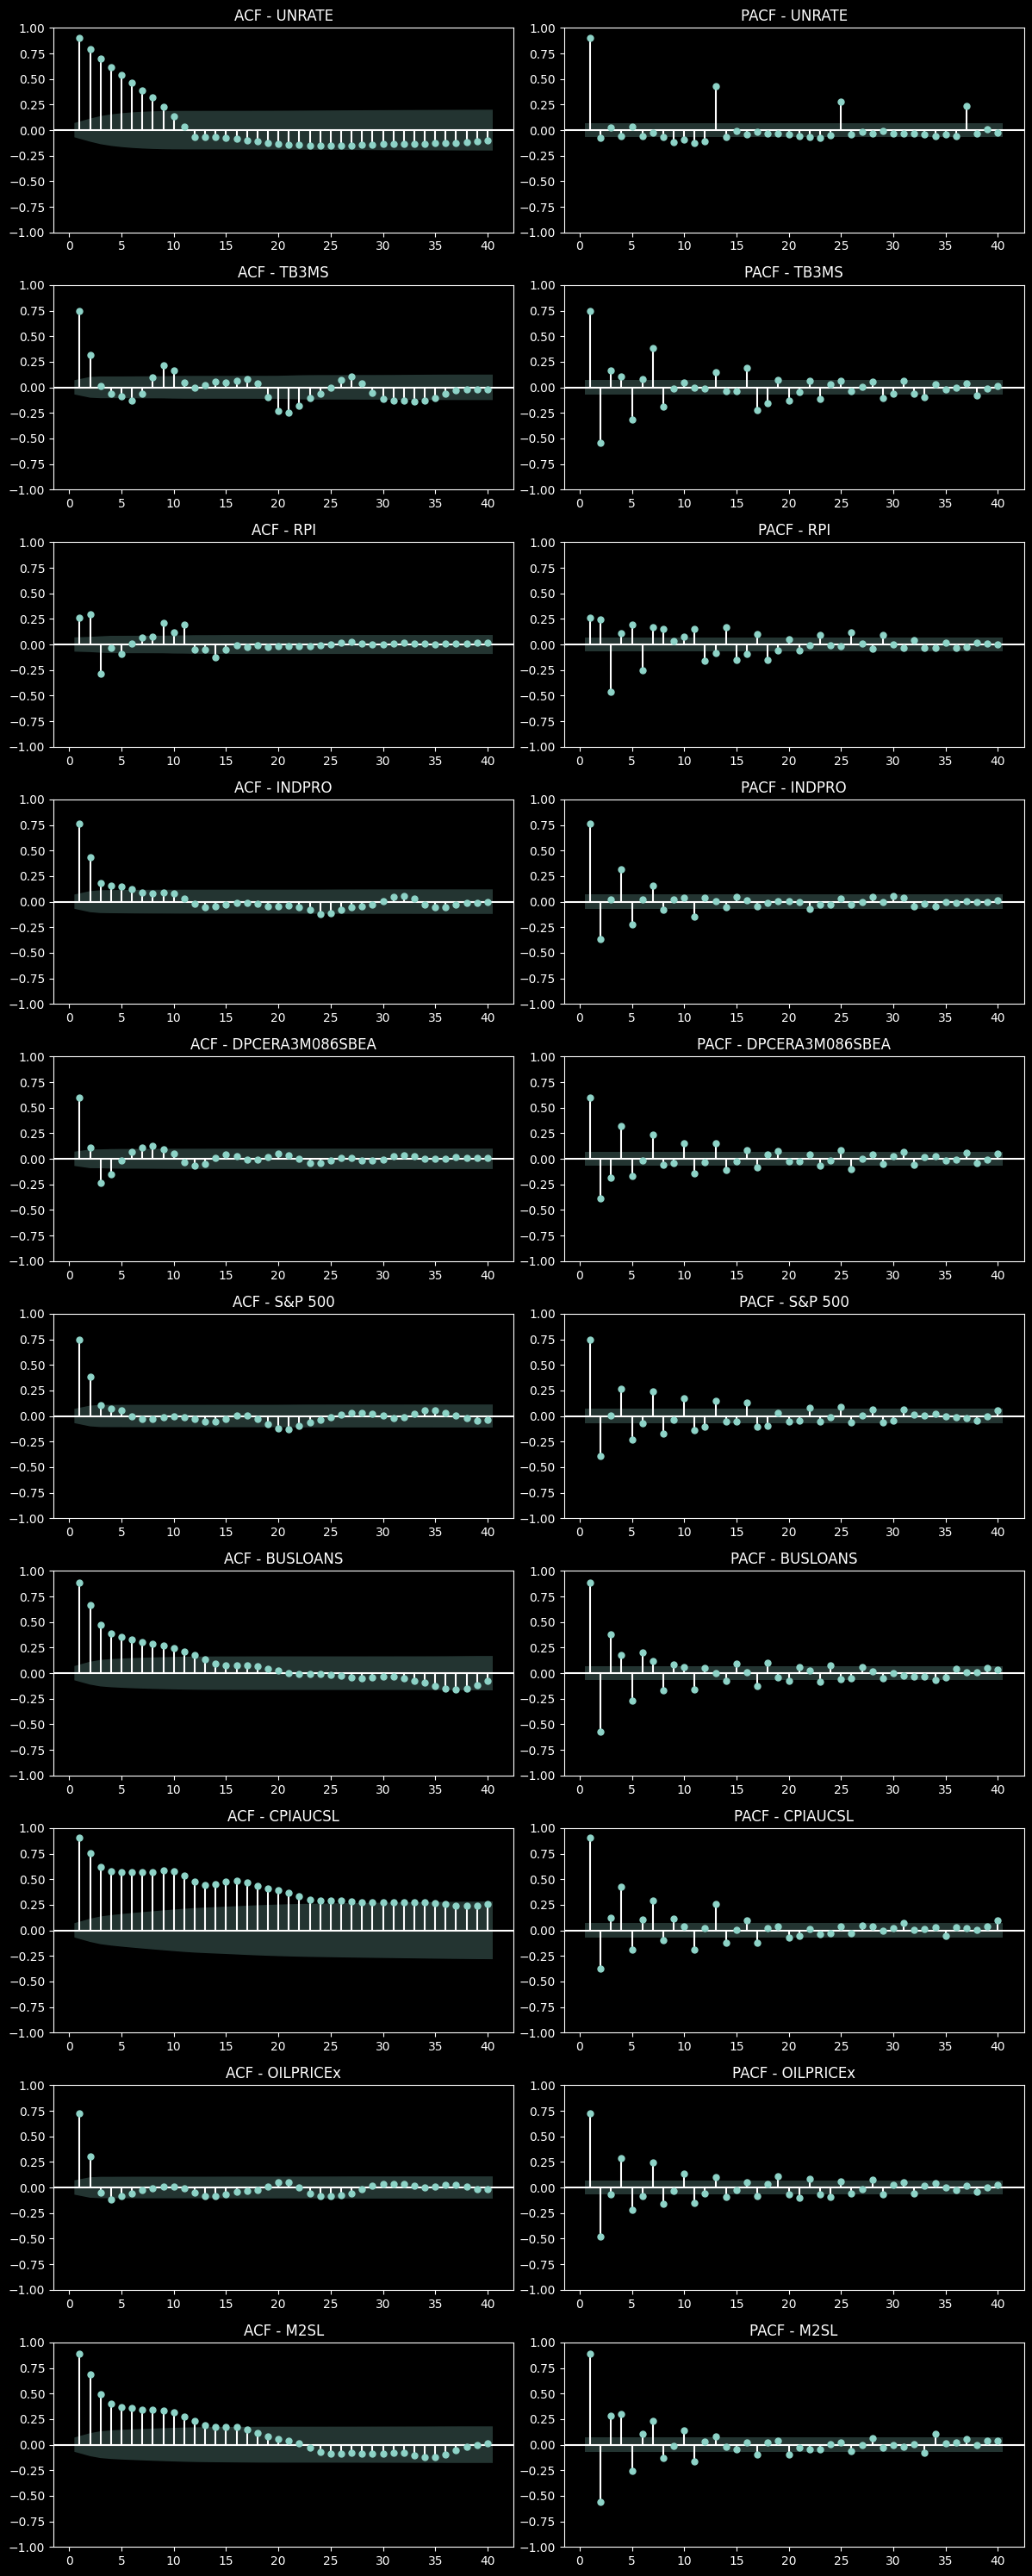

In [82]:
# Supposons que df_stationary est ton DataFrame stationnaire
n_series = len(df_stationary.columns)
fig, axes = plt.subplots(n_series, 2, figsize=(12, 3*n_series))

for i, col in enumerate(df_stationary.columns):
    # ACF à gauche
    plot_acf(df_stationary[col].dropna(), lags=40, ax=axes[i, 0], zero=False)
    axes[i, 0].set_title(f"ACF - {col}")
    
    # PACF à droite
    plot_pacf(df_stationary[col].dropna(), lags=40, ax=axes[i, 1], zero=False)
    axes[i, 1].set_title(f"PACF - {col}")

plt.tight_layout()
plt.show()

**Règle d'interprétation**
- Mémoire (via l’ACF)
    - ACF qui décroît rapidement → mémoire courte
    - ACF qui décroît lentement → mémoire longue

- Lecture conjointe ACF / PACF
    - PACF avec quelques pics nets et ACF qui décroît → dépendance concentrée sur peu de retards
    - ACF avec quelques pics nets et PACF qui décroît → influence marquée de chocs passés
    - ACF et PACF qui décroissent progressivement → structure plus persistante et étalée dans le temps

- Règle générale
    - Mémoire courte : dépendance limitée dans le temps.
    - Mémoire longue : persistance importante et durable des effets passés.

**interprétation**

- L’ACF/PACF met en évidence une mémoire longue pour UNRATE, BUSLOANS, M2SL et CPIAUSL. Ces séries montrent une forte persistance des valeurs passées. Elles peuvent nécessiter un traitement plus marqué, par exemple une différenciation supplémentaire ou l’ajout de plusieurs retards.

- À l’inverse, TB3MS, RPI, INDPRO, DPCE, S&P500 et OILPRICEx présentent une mémoire courte. Leur dépendance temporelle s’atténue rapidement. Un traitement plus léger suffit généralement, avec seulement quelques retards à intégrer.

**Suite**
La justification d'une différenciation de seconde ordre ne s'effectue pas uniquement sur l'analyse de l'autocorrélation. Elle est complémentaire avec celle de la volatilité.

# Analyse de la volatilité des predicators

**Règle de volatilité**

une série est d’autant plus volatile que son rolling standard deviation varie beaucoup et atteint souvent des amplitudes élevées. 

<Axes: title={'center': 'Volatilité glissante (12 mois)'}, xlabel='date'>

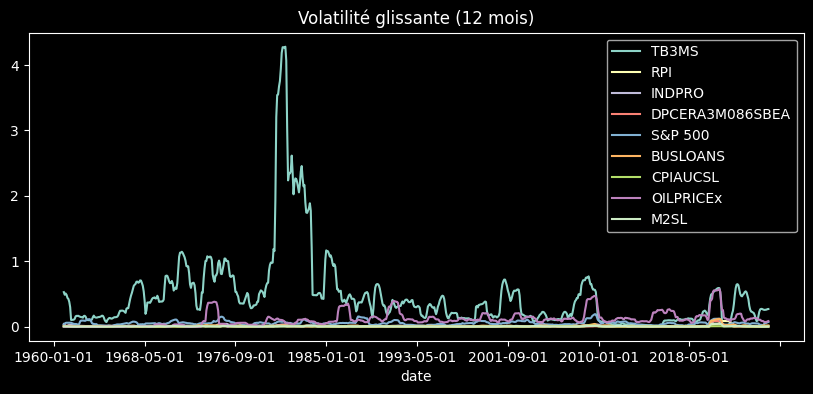

In [105]:
# Retirer UNRATE et TB3MS
df_fin = df_stationary.drop(columns=["UNRATE"])

# Volatilité glissante sur 12 mois
roll_vol = df_fin.rolling(12).std()

# Affichage
roll_vol.plot(figsize=(10,4), title="Volatilité glissante (12 mois)")

Le TB3MS est la plus volatile parce que les taux courts réagissent directement et brutalement aux politiques monétaires et aux crises. 

Nous n'allons pas différencier pour la 2nd fois le taux TB3MS, c'est pour avoir une interprétation économique en termes de croissance. 

Enlevons TB3MS dans le graphique pour voir la volatilité des autres prédicateurs.

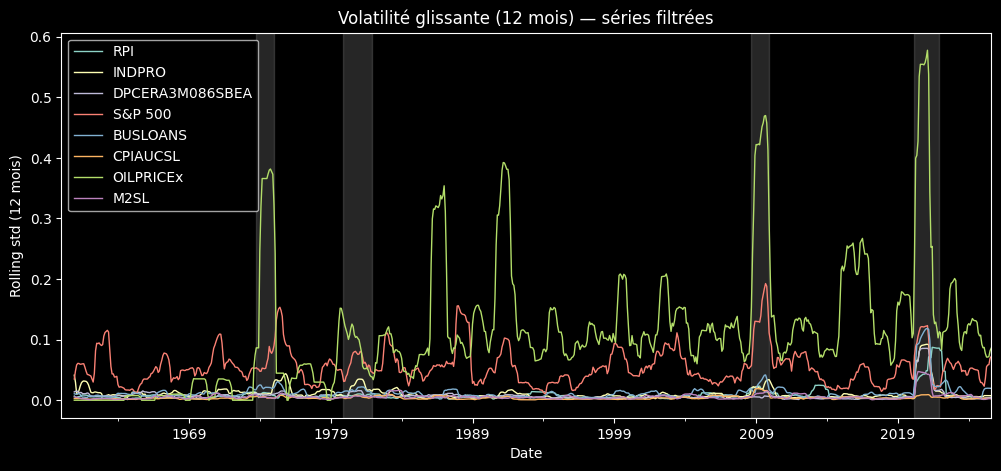

In [ ]:
# 1) Rolling std sans UNRATE et TB3MS
df_fin = df_stationary.drop(columns=["UNRATE", "TB3MS"], errors="ignore")
roll_vol = df_fin.rolling(12).std()

# 2) Forcer un index temporel propre (mensuel, début de mois)
roll_vol.index = pd.to_datetime(roll_vol.index).to_period("M").to_timestamp()

# 3) Plot
plt.style.use("dark_background")
ax = roll_vol.plot(figsize=(12,5), linewidth=1, title="Volatilité glissante (12 mois) — séries filtrées")

# 4) Bandes de chocs (dates simples)
bands = [
    ("1973-10", "1975-01"),
    ("1979-11", "1981-12"),
    ("2008-09", "2009-12"),
    ("2020-03", "2021-12"),
]

for start, end in bands:
    ax.axvspan(pd.to_datetime(start), pd.to_datetime(end), color="grey", alpha=0.3)

# 5) Mise en forme
ax.set_xlabel("Date")
ax.set_ylabel("Rolling std (12 mois)")

plt.show()

**interprétation**

Le graphique montre que OILPRICEx est la série la plus volatile, car elle présente de nombreux pics, très haute amplitude, montées et descentes rapides. 

le prix du pétrole réagit immédiatement aux chocs mondiaux (géopolitique, OPEP, crises, récessions).

OILPRICEx exige alors une seconde différenciation.

**2nd différenciation pour**
- OILPRICEx
- BUSLOANS
- M2SL
- CPIAUSL

# 6) Différenciation de second ordre

In [120]:
# --- Δ²log avec lag=3 ---
def d2log(series, l=3):
    s = pd.Series(series).astype(float)
    s = s.where(s > 0)           # log sûr (ignore <= 0)
    return np.log(s).diff(l).diff(l)

In [121]:
# + OILPRICEx (ajuste le nom si différent chez toi)
cols_d2log = ["BUSLOANS", "CPIAUCSL", "M2SL", "OILPRICEx"]
cols_d2log = [c for c in cols_d2log if c in df.columns]

In [122]:
# 1) Transformer
df_d2 = pd.DataFrame({c: d2log(df[c], l=3) for c in cols_d2log})
df_d2 = df_d2.dropna(how="any")

print("=== Δ²log (lag=3) — premières lignes ===")
print(df_d2.head())

=== Δ²log (lag=3) — premières lignes ===
            BUSLOANS  CPIAUCSL      M2SL  OILPRICEx
date                                               
1959-07-01  0.047797  0.006884  0.005289    0.01005
1959-08-01  0.017554  0.003431 -0.001249    0.01005
1959-09-01 -0.025926 -0.000023 -0.008000    0.00000
1959-10-01 -0.037916  0.000989 -0.013033    0.00000
1959-11-01 -0.032074  0.001000 -0.011913    0.00000


In [123]:
# 2) Vérifier ADF (constante seule, adapté à des séries déjà différenciées)
rows = []
for c in df_d2.columns:
    y = df_d2[c].replace([np.inf, -np.inf], np.nan).dropna()
    stat, pval, usedlag, nobs, *_ = adfuller(y, regression="c", autolag="AIC")
    rows.append({"series": c, "ADF stat": stat, "p-value": pval, "lags(ADF)": usedlag, "nobs": nobs,
                 "verdict": "Stationary" if pval < 0.05 else "Non-stationary"})
summary_d2 = pd.DataFrame(rows).set_index("series").sort_index()

In [124]:
print("\n=== Résumé ADF (Δ²log, lag=3) ===")
print(summary_d2)


=== Résumé ADF (Δ²log, lag=3) ===
           ADF stat       p-value  lags(ADF)  nobs     verdict
series                                                        
BUSLOANS  -7.132520  3.487916e-10         21   772  Stationary
CPIAUCSL  -5.869776  3.260849e-07         21   772  Stationary
M2SL      -7.388155  8.133021e-11         19   774  Stationary
OILPRICEx -8.250778  5.398469e-13         21   772  Stationary


# 7) Combinaison des données

In [138]:
# --- 1) Helper: Δ² log avec fenêtre l ---
def d2log(series: pd.Series, l: int = 3, eps: float = 1e-6) -> pd.Series:
    s = pd.Series(series, dtype=float)
    s = s.clip(lower=eps)                # évite log(0) et négatifs
    return np.log(s).diff(l).diff(l)     # Δ_l^2 log

In [139]:
# --- 2) Colonnes à transformer (seulement celles présentes) ---
cols_d2log = [c for c in ["BUSLOANS", "CPIAUCSL", "M2SL", "OILPRICEx"] if c in df.columns]

In [140]:
# --- 3) Appliquer Δ²log(l=3) sur df brut et ALIGNER sur l'index de df_stationary ---
df_d2 = pd.DataFrame({c: d2log(df[c], l=3) for c in cols_d2log})
# Aligner pour garantir la correspondance d'index (important pour update)
df_d2 = df_d2.reindex(df_stationary.index)

In [141]:
# --- 4) Mettre à jour df_stationary avec les colonnes Δ²log ---
df_stationary = df_stationary.copy()
df_stationary.update(df_d2)              # remplace seulement les colonnes ciblées

In [142]:
# --- 5) Nettoyage : Remplacer inf/ninf par NaN
df_stationary.replace([np.inf, -np.inf], np.nan, inplace=True)
# Ne dropper que si NaN dans les colonnes modifiées (évite de perdre d'autres séries)
if cols_d2log:
    df_stationary = df_stationary.dropna(subset=cols_d2log)

In [143]:
# --- 6) (Optionnel mais recommandé) Mettre à jour summary_all pour refléter d=2 ---
if "summary_all" in globals():
    summary_all = summary_all.copy()
    # Si l'index de summary_all est 'series', on met à jour directement
    # Sinon, essaye d'abord de le remettre avec 'series' en index si besoin
    if "series" in summary_all.columns and not summary_all.index.name == "series":
        summary_all = summary_all.set_index("series")

    mask = summary_all.index.isin(cols_d2log)
    if mask.any():
        summary_all.loc[mask, "method"] = "Δ² log (l=3)"
        summary_all.loc[mask, "order"]  = 2
        # s'assurer de l'entier
        try:
            summary_all["order"] = summary_all["order"].astype(int)
        except Exception:
            pass

In [144]:
rows = []

for c in cols_d2log:
    y = df_stationary[c].astype(float).replace([np.inf, -np.inf], np.nan).dropna()

    res = adf_test(y, alpha=0.05, regression="c", autolag="AIC")

    if not res.get("ok", False):
        rows.append({"ADF p-value": np.nan, "Verdict": "Série trop courte"})
        continue

    verdict = "Stationnaire" if res["stationary"] else "Non-stationnaire"
    rows.append({
        "ADF p-value": res["pval"],
        "Verdict": verdict
    })

summary = pd.DataFrame(rows, index=cols_d2log)
print(summary)

            ADF p-value       Verdict
BUSLOANS   4.267894e-10  Stationnaire
CPIAUCSL   3.721934e-07  Stationnaire
M2SL       9.985381e-11  Stationnaire
OILPRICEx  6.558137e-13  Stationnaire


Maintenant qu'on a toutes les séries temporelles stationnaires, il nous reste à télécharger l'indicateur de récession.

# 8) Combiner les indicateurs de récession aux données stationnaires

In [172]:
# 1) 
usrec = (
    web.DataReader("USRECDM", "fred", start="1959-01-01")
      .resample("M").max()
      .rename(columns={"USRECDM": "USREC"})
)
usrec.index = usrec.index.to_period("M").to_timestamp("M")
usrec["USREC"] = usrec["USREC"].astype("int8")

# Vérifier la répartition (optionnel)
print(pd.crosstab(index=usrec["USREC"], columns="count"))

# 2) Nettoyage des anciennes colonnes USREC_* s’il y en a
cols_to_drop = [c for c in df_stationary.columns if c.startswith("USREC")]
df_stationary = df_stationary.drop(columns=cols_to_drop, errors="ignore")

# 3) Harmoniser les index en fin de mois
df_stationary.index = pd.to_datetime(df_stationary.index)
df_stationary.index = df_stationary.index.to_period("M").to_timestamp("M")

# 4) Ajouter la série de récession alignée
df_stationary["USREC"] = usrec["USREC"].reindex(df_stationary.index)

col_0  count
USREC       
0        698
1        104


C:\Users\Mita\AppData\Local\Temp\ipykernel_17028\1011799456.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample("M").max()


In [173]:
# ✅ Résultat final : df_stationary propre et synchronisé
print(df_stationary.head())

            UNRATE  TB3MS       RPI    INDPRO  DPCERA3M086SBEA   S&P 500  \
date                                                                       
1960-01-31    -0.8   0.30  0.020977  0.091980         0.001204  0.017909   
1960-02-29    -1.1  -0.19  0.014565  0.076964         0.006009 -0.025663   
1960-03-31    -0.2  -1.18  0.006250  0.007961         0.021240 -0.070857   
1960-04-30     0.0  -1.12  0.006489 -0.025915         0.033752 -0.040442   
1960-05-31     0.0  -0.67  0.007747 -0.018121         0.009040 -0.010090   

            BUSLOANS  CPIAUCSL  OILPRICEx      M2SL  USREC  
date                                                        
1960-01-31  0.011578 -0.006156        0.0  0.001323      0  
1960-02-29  0.011905 -0.003767        0.0  0.002007      0  
1960-03-31 -0.008356 -0.005455        0.0  0.001324      0  
1960-04-30 -0.009098  0.005090        0.0  0.000634      1  
1960-05-31 -0.000359  0.003383        0.0  0.003977      1  


Présentons graphiquement les séries stationnaires ainsi que USREC pour vérifier nos changements.

# 9) Graphiques des variables originales et stationnaires côte à côte

In [174]:
# --- Stationnaire -> format long ---
df_stationary = df_stationary.copy()
df_stationary.attrs.clear()                  # évite l'erreur au melt s'il y a des attrs
df_stationary.index.name = "date"
df_stationary.index = pd.to_datetime(df_stationary.index)

df_long_stationary = (
    df_stationary
      .reset_index()
      .melt(id_vars="date", var_name="series", value_name="value")
      .dropna(subset=["value"])
      .sort_values(["series", "date"])
      .reset_index(drop=True)
)

# (Optionnel) joindre les métadonnées "method" et "order"
if "summary_all" in globals():
    meta = summary_all[["method", "order"]].reset_index()
    df_long_stationary = df_long_stationary.merge(meta, on="series", how="left")

print(df_long_stationary.head())

        date    series     value
0 1960-01-31  BUSLOANS  0.011578
1 1960-02-29  BUSLOANS  0.011905
2 1960-03-31  BUSLOANS -0.008356
3 1960-04-30  BUSLOANS -0.009098
4 1960-05-31  BUSLOANS -0.000359


In [176]:
# --- Préparer la méthode par série et l'info "double diff" ---
method_map = results_df["method"].to_dict()

d2_series = set()
if "summary_d2" in globals() and summary_d2 is not None:
    try:
        d2_series = set(summary_d2.index)
    except Exception:
        d2_series = set()

def format_method_for_title(series):
    """Insère Δ² si double différence, sinon Δ intact. Garde le texte d'origine."""
    base = method_map.get(series, "").strip()
    if not base:
        return "méthode inconnue"
    if series in d2_series:
        # remplace uniquement la 1ère occurrence de Δ par Δ²
        return base.replace("Δ", "Δ²", 1)
    return base

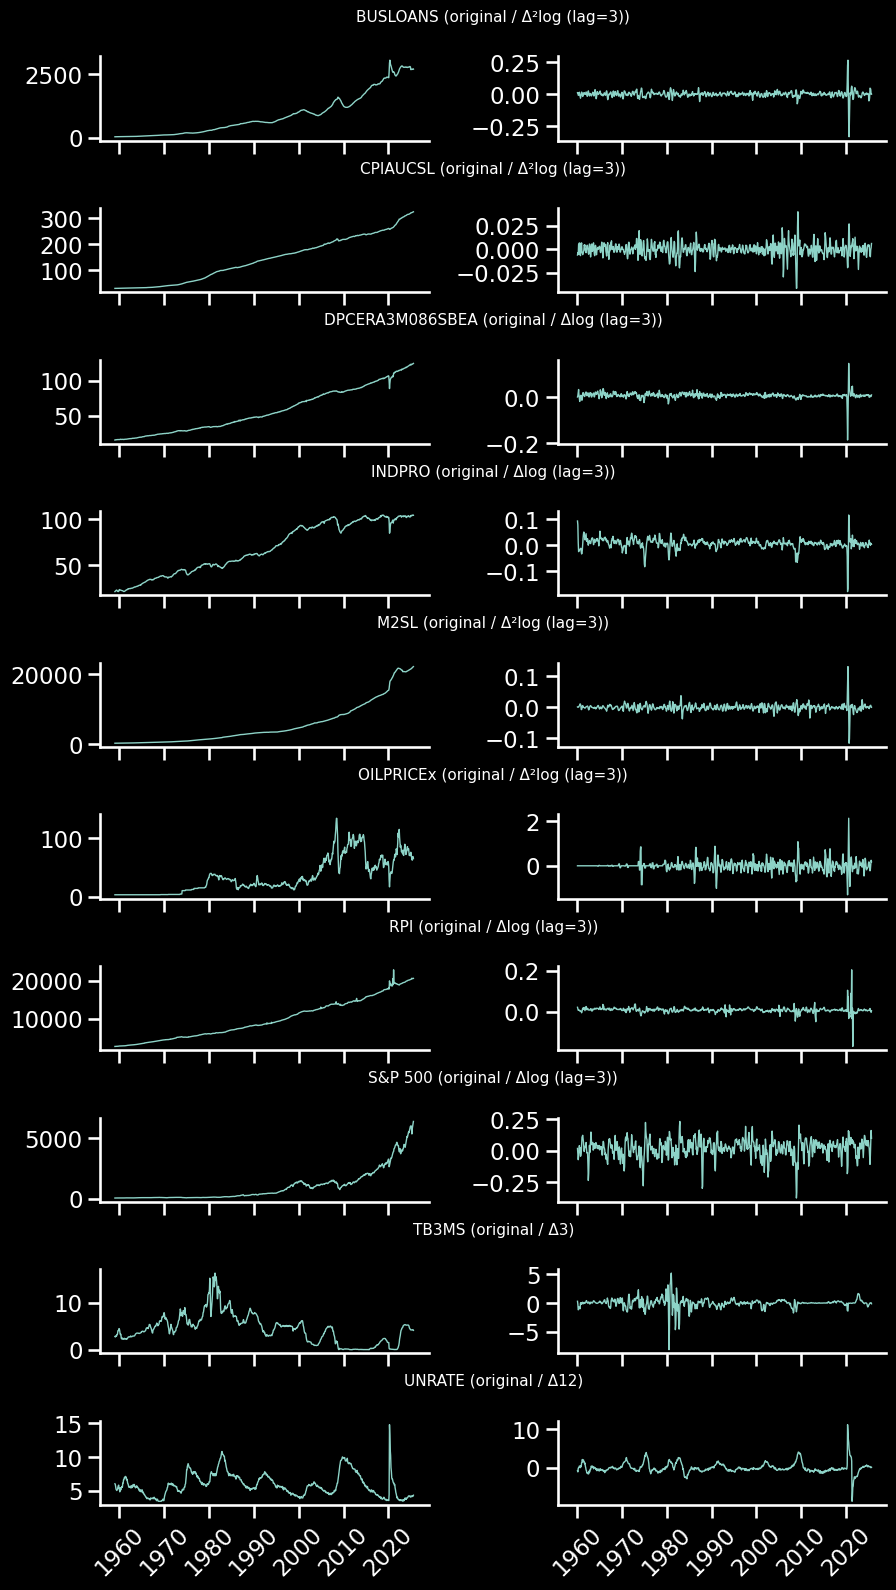

In [177]:
# --- Plot côte à côte (déjà construit plus haut : df_plot) ---
plt.style.use("dark_background")
sns.set_context("talk")

g = sns.relplot(
    data=df_plot,
    x="date", y="value",
    row="series",                         # 1 ligne = 1 série
    col="type",                           # Colonne 1 = Original, colonne 2 = Stationnaire
    col_order=["Original", "Stationnaire"],
    kind="line", linewidth=1,
    facet_kws=dict(sharey=False),         # mettre sharey="row" si tu veux même échelle Y
    hue=None, legend=False,
    height=1.6, aspect=3
)

# On enlève les titres par sous-graphe, on va mettre un titre commun par ligne
g.set_titles("")
g.set_axis_labels("", "")

# Ajout d'un titre commun par ligne : "SERIE (original / <méthode>)"
for i, serie in enumerate(g.row_names):
    # Récupérer les deux axes de la ligne
    left_ax  = g.axes[i, 0]
    right_ax = g.axes[i, 1]

    # Titre formaté avec Δ² si besoin
    method_txt = format_method_for_title(serie)
    row_title = f"{serie} (original / {method_txt})"

    # Calcul de la position centrée au-dessus des deux axes
    left_pos  = left_ax.get_position()
    right_pos = right_ax.get_position()
    x_center = (left_pos.x0 + right_pos.x1) / 2
    y_top    = left_pos.y1 + 0.02  # petit offset au-dessus des axes

    g.fig.text(x_center, y_top, row_title,
               ha="center", va="bottom",
               fontsize=11, color="white")

# Formatage des axes temps
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
for ax in g.axes.flat:
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    ax.tick_params(axis="x", labelrotation=45, colors="white")
    ax.tick_params(axis="y", colors="white")
    ax.grid(False)

plt.show()

Nous constatons que les transformations appliquées ont bien fonctionné : la tendance (ou drift) a été supprimée et les séries sont désormais stationnaires. Elles oscillent autour d’une moyenne proche de zéro, sans dérive apparente. 

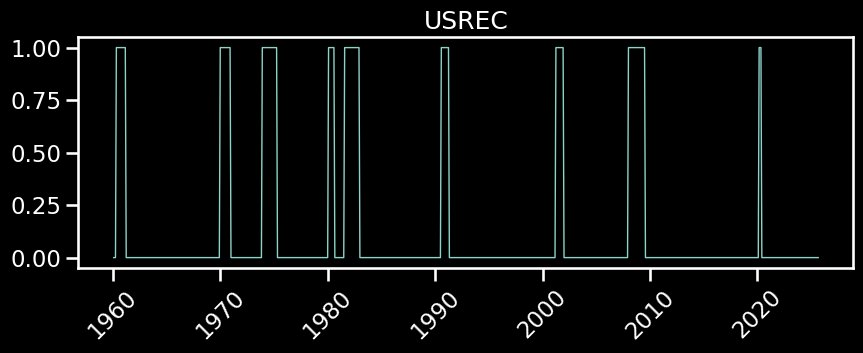

In [180]:
# === Plot USREC seule ===
plt.style.use("dark_background")
sns.set_context("talk")

plt.figure(figsize=(10, 3))
plt.plot(df_stationary.index, df_stationary["USREC"], linewidth=1)

plt.title("USREC", color="white")
plt.xlabel("")
plt.ylabel("")

locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
ax = plt.gca()
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

ax.tick_params(axis="x", labelrotation=45, colors="white")
ax.tick_params(axis="y", colors="white")
ax.grid(False)

plt.show()

La variable USREC est binaire pour indiquer la période de Récession.

# Exporter la série stationnaire

In [151]:
df.to_csv("df.csv")
df_stationary.to_csv("df_stationary.csv")